# 18.S097/16.S092 Problem Set 1 Solutions

## Problem 1 (5+5+5+5 points)

Suppose that you are solving $Ax = b$ where $A$ is an $m \times m$ (real) matrix of the form
$$
A = S + uv^T
$$
where $S$ is a *sparse* matrix (with $K$ nonzero entries) and $u,v$ are two $m$-component vectors.  That is, $A$ is the sum of a sparse matrix and a **rank-1** matrix.   We want to solve this efficiently for large $m$, even though $A$ itself is not sparse!

**(a)** For example, give possible vectors $u,v$ if 
$$
uv^T = \alpha \begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \end{pmatrix}
$$
or
$$
uv^T = \alpha \begin{pmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 1 & 1 & 1 & 1 \end{pmatrix}
$$
for some scalar $\alpha$.

**(b)** Explain why you can efficiently multiply $A$ by any vector $x$, in cost *much* better than $O(m^2)$.  Give the complexity of your algorithm $O(\cdots)$ in terms of $K$ and $m$.

**(c)** Show by explicit multiplication $AA^{-1} = I$ that $A^{-1} = S^{-1} - \frac{S^{-1} u v^T S^{-1}}{1 + v^T S^{-1} u}$.

**(d)** Assume that $S$ has an efficient (low-fill-in) sparse LU factorization $PSP^T = LU$, with $P$ being a permutation of the rows and columns ($P^{-1} = P^T$, like any permutation).   Explain how you can exploit this to efficiently solve $Ax = b$ (using the formula from part **c**).

*Note:* Don't try to compute $S^{-1}$ explicitly — it is probably not sparse!  Note that solving a triangular system like $Ly = c$ or $Uy = c$ is very efficient given sparse $L$ and $U$ vectors.  Also, permuting a vector, like $Py$ or $P^Ty$, can be done in $O(m)$ operations.

### Solutions:

**(a)** These can be factored as:

$$
\alpha \begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 \end{pmatrix} =
\boxed{\underbrace{\alpha \begin{pmatrix} 1 \\ 1 \\ 1 \\ 1 \end{pmatrix}}_u \underbrace{\begin{pmatrix} 1 & 1 & 1 & 1 \end{pmatrix}}_v}
$$
and
$$
\alpha \begin{pmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 1 & 1 & 1 & 1 \end{pmatrix} =
\boxed{\underbrace{\alpha \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \end{pmatrix}}_u \underbrace{\begin{pmatrix} 1 & 1 & 1 & 1 \end{pmatrix}}_v} \, ,
$$
respectively.  Of course, the choice of $u,v$ here is not unique — we can rescale them in various ways, as long as the scale factors multiply out to $\alpha$.


**(b)** If we just put parentheses in the right places to indicate the order of operations, we get:
$$
\boxed{Ax = Sx + u(v^T x)} \, .
$$
Computing $Sx$ is $O(K)$ because you only have to multiply/add nonzero entries, computing $v^T x$ is $O(m)$ ($m$ multiplications and $m-1$ additions) then multiplying the resulting scalar by $u$ is also $m$ multiplications.  So the overall cost is $\boxed{O(K + m)}$.

**(c)** This is the famous [Sherman–Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) for the inverse of a rank-1 update.  By explicit multiplication, we get:
\begin{aligned}
AA^{-1} &= \left( S + uv^T \right) \left(S^{-1} - \frac{S^{-1} u v^T S^{-1}}{1 + v^T S^{-1} u}\right) \\
&= \cancelto{I}{S S^{-1}} + uv^T S^{-1} - \frac{\cancelto{I}{S S^{-1}} u v^T S^{-1}}{1 + v^T S^{-1} u} 
- \frac{u(v^T S^{-1} u) v^T S^{-1}}{1 + v^T S^{-1} u} \\
&= I + uv^T S^{-1} - \frac{u v^T S^{-1}}{1 + v^T S^{-1} u} 
- \frac{u v^T S^{-1} (v^T S^{-1} u)}{1 + v^T S^{-1} u} \\ 
&= I + uv^T S^{-1}  
- \frac{u v^T S^{-1} \cancel{(1 + v^T S^{-1} u)}}{\cancel{1 + v^T S^{-1} u}}  = \boxed{I} \, .
\end{aligned}
A key step here is realizing that $v^T S^{-1} u$ is a scalar, so it can be commuted freely with other multiplications (unlike matrices).

**(d)** We want to compute
$$
x = A^{-1}b = \boxed{\overbrace{(S^{-1} b)}^c - \frac{\overbrace{(S^{-1} u)}^d \left[v^T \overbrace{(S^{-1} b)}^c\right]}{1 + v^T \underbrace{(S^{-1} u)}_d}} \, ,
$$
where I've used parentheses to indicate an efficient order of operations.  Since $PSP^T = LU$, we have $S = P^T L U P \implies S^{-1} = P^T U^{-1} L^{-1} P$.  This allows us to do:

1. First, compute $c = S^{-1} b = P^T (U^{-1} (L^{-1} (P b)))$, performing the operations from right-to-left as indicated by parentheses: a permutation $Pb$ followed by two sparse triangular solves (forward- then back-substitution), followed by a permuation $P^T$.  The permuations are linear time, and the triangular solves are efficient as long as there wasn't too much fill-in, as noted.
2. Then compute $d = S^{-1} u$ in the same way: permutation, two sparse triangular solves, permutation.
3. Finally, compute $x = c + \frac{d (v^T c)}{1 + v^T d}$, which is $O(m)$ (just some dot products, vector-scalar multiplications, and vector addition).

## Problem 2 (10+10 points)

[Niu et al. (2014)](https://aapm.onlinelibrary.wiley.com/doi/10.1118/1.4866386) describe an optimization problem (equation 12) to solve for an unknown vector $x \in \mathbb{R}^{2N}$ whose entries describe the pixels of a medical image to be reconstructed from measurements.

You *don't* need to understand any of the physics, statistics, or interpretation of this paper.  You just need to be able to decipher the *math* of sections 2.A–2.C and **translate it into linear algebra**.  This is an important skill!

**(a)** Show that equation 12 of this paper is equivalent to a quadratic optimization problem
$$
\min_{x} \left[ x^T M x - b^T x + \alpha \right]
$$
for some symmetric matrix $M = M^T$ and vector $b$ and a scalar $\alpha$  (all independent of $x$), each of which can be computed efficiently.  (In fact, it is a *convex* quadratic problem because all of the terms are strictly nonnegative, but you need not show that.)

Hence, by taking the gradient $\nabla_x (x^T M x - b^T x + \alpha)$ and setting it to zero, we obtain a simple linear system $Mx = b/2$ that we could solve for $x$.

**(b)** Explain why your matrix $M$ is very *sparse* matrix (only a small number of nonzero entries per row).

Hence you could solve for $x$ efficiently assuming we have a good way to solve sparse linear systems (e.g. a sparse-direct solver, though in the paper they eventually use a conjugate-gradient algorithm instead).

### Solution:

**(a)** Equation 12 in the paper is:
$$
\min_x (A x - \mu)^T V^{-1} (A x - \mu) + \lambda R(x) \,
$$
where $A, V$ are given matrices ($V = V^T$ is diagonal), $\mu$ is a given vector, $\lambda$ is a scalar, and $R(x)$ is given by equation (13) in the paper:
$$
R(x) = \frac{1}{2} \sum_i \sum_{k \in N_i} e_{i,k} (x_i - x_k)^2 \,
$$
where $N_i$ is the set of 4 neighbors of pixel $i$, and $e_{i,k}$ are given numbers.  It should be pretty obvious from looking at these equations that they are quadratic (and in fact convex quadratic).   To put them in the requested $x^T M x - b^T x + \alpha$ form, we just need to do a little re-arranging.  The first terms are:
$$
x^T (A^T V^{-1} A) x - (2 A^T V^{-1} \mu)^T x + \mu^T V^{-1} \mu
$$
which is now in the desired form.  To put $R(x)$ in the requested form, it is convenient to define a matrix $D$ such that $Dx$ gives the vector of all differences $x_i - x_k$ between $x_i$ components and the nearest neighbors $N_i$.   Note that $D$ will not be square, it will be a "tall" matrix $(\sum_i |N_i|) \times 2N = 8N \times N$ since the paper says that each pixel $i$ has 4 neighbors (or maybe slightly fewer at image edges? not our problem).  In terms of $Dx$, the regularization $R(x)$ is simply:
$$
R(x) = \frac{1}{2} (Dx)^T E (Dx)
$$
where $E$ is a diagonal matrix of the $e_{i,k}$ "edge" weights.

Hence, we have the requested form $x^T M x - b^T x + \alpha$ where
1. $M = \boxed{A^T V^{-1} A + \frac{\lambda}{2} D^T E D}$
2. $b = \boxed{2 A^T V^{-1} \mu}$
3. $\alpha = \boxed{\mu^T V^{-1} \mu}$

**(b)** If you peruse the paper, it is easy to see that all of the matrices appearing in the above expressions are sparse:

1. From equation (3) in the paper, $A = \begin{pmatrix} \mu_{\text{1H}} I & \mu_{\text{2H}} I \\ \mu_{\text{1L}} I & \mu_{\text{2L}} I \end{pmatrix}$ consists of four scaled copies of the identity matrix, with only 2 nonzero entries per row.
2. From equation (11) in the paper $V$ (and hence $V^{-1}$) is a diagonal matrix.
3. Our difference matrix $D$ has only two nonzero entries per row ($\pm 1$), since each row take the difference of two pixels.
4. Our matrix $E$ is diagonal.

Hence the matrix $M$, which consists of sums of products of sparse matrices, is also sparse.  (And $b$ is easy to compute from sparse matrix–vector multiplication.)

## Problem 3 (5 + 5 + 10 points)

Suppose that $A = A^T $ is the symmetric $m \times m$ "banded" matrix:
$$
A = \begin{pmatrix} a_1 & b_1 & c_1 & & & & & & &\\
b_1 & a_2 & b_2 & c_2 & & & & &\\
c_1 & b_2 & a_3 & b_3 & c_3 & & & & & \\
& c_2 & b_3 & a_4 & b_4 & c_4 & & & & \\
& & c_3 & b_4 & a_5 & b_5 & c_5 & & & \\
& & & \ddots & \ddots & \ddots & \ddots & \ddots & & \\
& & &  & c_{m-4} & b_{m-3} & a_{m-2} & b_{m-2} & c_{m-2} \\
& & & &  & c_{m-3} & b_{m-2} & a_{m-1} & b_{m-1} \\
& & & & &  & c_{m-2} & b_{m-1} & a_m
\end{pmatrix}
$$
which is defined in terms of three vectors $a \in \mathbb{R}^m$, $c \in \mathbb{R}^{m-1}$, and $c \in \mathbb{R}^{m-2}$.

**(a)** Sketch the sparsity pattern of this matrix as a graph, as defined in class ($m$ nodes representing rows and columns, with edges representing nonzero entries).   You can assume all of the elements of $a,b,c$ are nonzero.

**(b)** Write code (in Julia using the `SparseArrays` package, or in Python with `scipy.sparse`) that creates an (unstructured) sparse matrix $A$ given vectors $a,b,c$.   (The function `spdiagm` in Julia or `diags_array` in Python might be helpful.)  Plot the sparsity pattern (e.g. with `pyplot.spy`) for $m = 20$ to make sure it looks right.

**(c)** Benchmark the performance (for a set of logarithmically spaced $m$ values up to $m = 10^7$) of solving $A x = y$ (e.g with `x = A \ y` in Julia or `spsolve` in Python) for random $a,b,c,y$ and plot it as a function of $m$ on a log–log scale.  What power-law do you observe?  Does it make sense given the material from class?

### Solutions

**(a)** The graph has $m$ nodes, most naturally arranged into a line corresponding to rows/columns $1,2,\ldots,m$, and each node is connected to its neighbors (by $b_k$) and to its second neighbors (by $c_k$), except for the beginning and ending nodes which have fewer neighbors.   One could also show edges connecting each node to itself, corresponding to the diagonal elements $a_k$, but as mentioned in class we typically omit those from such diagrams.

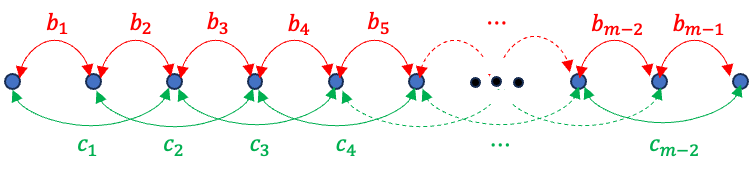

Since it is a symmetric matrix, each edge has two arrows, or equivalently we could omit the arrows and show it as an undirected graph.

**(b)** Note that a banded matrix could be viewed as a structured sparse matrix, because the pattern of nonzero entries is very regular, but we will store it an an *unstructured sparse-matrix format*, i.e. a format that could handle *any* nonzero pattern and doesn't "know" the banded structure.  The resulting `A \ b` sparse-direct solver algorithm will therefore be generic to any sparsity pattern (though it will try to apply graph-analysis algorithms to take advantage of whatever structure it can find).   (In contrast, the Julia [BandedMatrices.jl package](https://github.com/JuliaLinearAlgebra/BandedMatrices.jl) defines structured-sparse formats and solver algorithms that are specialized to banded matrices.)

We'll implement this in Julia, writing a function `A3(a,b,c)` to generate such a matrix given $a,b,c$ via the `spdiagm` function as suggested.  We'll also define `A3(m)` to generate an $m \times m$ such matrix with Gaussian random entries.

(If you are using the `scipy.sparse.diags_array` function in Python, you must pass a `format=...` argument to specify an unstructured sparse format like `'csc'` or `'coo'`.  Otherwise it may default to a `'dia'` format that is specialized to banded matrices.)

In [1]:
using SparseArrays

function A3(a::AbstractVector{<:Real}, b::AbstractVector{<:Real}, c::AbstractVector{<:Real})
    m = length(a)
    m == length(b)+1 == length(c)+2 || throw(DimensionMismatch())
    return spdiagm(m, m, 0=>a, 1=>b, -1=>b, 2=>c, -2=>c)
end

A3(m::Integer) = A3(randn(m), randn(m-1), randn(m-2))

A3 (generic function with 2 methods)

Before we plot the sparsity pattern, let's just look at it for a $6 \times 6$ case where `a = 1:6`, `b=7:11`, and `c = -4:-1`, so that we can see the values directly:

In [2]:
A3(1:6, 7:11, -4:-1)

6×6 SparseMatrixCSC{Int64, Int64} with 24 stored entries:
  1   7  -4   ⋅   ⋅   ⋅
  7   2   8  -3   ⋅   ⋅
 -4   8   3   9  -2   ⋅
  ⋅  -3   9   4  10  -1
  ⋅   ⋅  -2  10   5  11
  ⋅   ⋅   ⋅  -1  11   6

Looks good!  Now let's do the requested $20 \times 20$ plot, using the `spy` function in Julia's Plots.jl library:

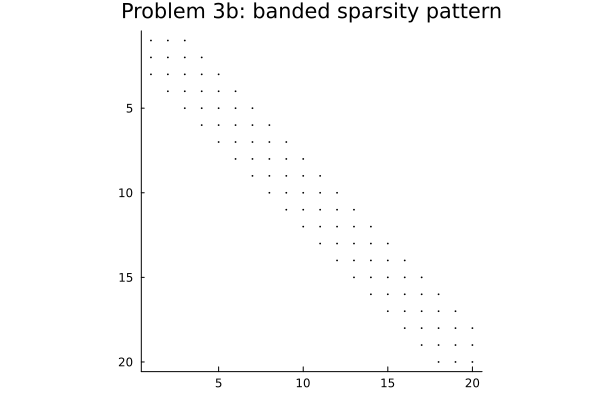

In [20]:
using Plots, LaTeXStrings
spy(A3(ones(20), ones(19), ones(18)), legend=nothing,
    title="Problem 3b: banded sparsity pattern")

Looks good!

**(c)** Now, let's do the suggested benchmark, for 20 log-spaced $m$ values from $m=100$ to $10^7$:

In [19]:
using Chairmarks

# log-spaced values from 10² to 10⁷, rounded to nearest integer
ms = round.(Int, logrange(10^2, 10^7, 20))
ts = map(ms) do m
    A, b = A3(m), b = randn(m) # random banded matrix and rhs
    bench = @b (A3(m),randn(m)) args -> (\)(args...)
    bench.time
end;

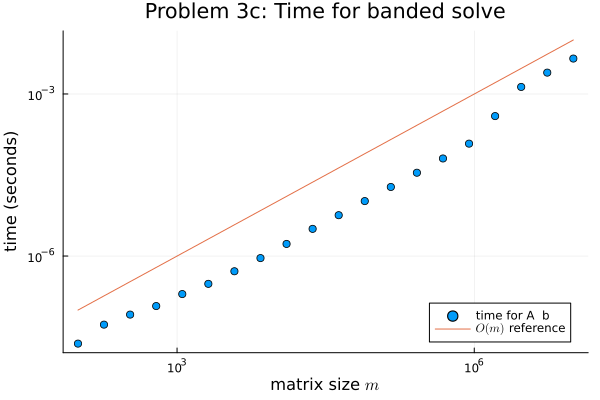

In [27]:
scatter(ms, ts, xaxis=:log10, yaxis=:log10, label="time for A \\ b")
plot!(ms, ms * 1e-9, label=L"$O(m)$ reference", legend=:bottomright,
      title="Problem 3c: Time for banded solve",
      xlabel=L"matrix size $m$", ylabel="time (seconds)")

From the plot, the scaling is roughly **linear** $\boxed{O(m)}$ time.

This indeed makes sense from the material in class, since a banded matrix is a "1d" graph: it can be partitioned into two disconnected pieces by removing only $O(1)$ nodes (in fact, only 2), independent of $m$, so that we expect nested-dissection and related sparse-direct algorithms to have linear scaling.

## Problem 4 (10 + 10 points)

In class (lecture 2) we defined the compressed-sparse-column (CSC) format, in which a sparse matrix is defined by three arrays (denoted in Matlab notation as `Pr, Ir, Jc` in the slides) of nonzero values by column (`Pr`), row indices (`Ir`), and the starting (1-based) index of each column (`Jc`).

As an example, `Pr = [31,41,59,26,53]`, `Ir = [1,3,2,3,1]`, and `Jc = [1,3,5,6]` describe the $3 \times 3$ "sparse" matrix:
$$
A = \begin{pmatrix} 31 & \cdot & 53 \\ \cdot & 59 & \cdot \\ 41 & 26 & \cdot \end{pmatrix}
$$
(where $\cdot$ indicates zero values that are not stored).

**(a)** Write a function `matvec(Pr, Ir, Jc, x)`, in the language of your choice, that returns the matrix-vector product `A*x` given the `Pr,Ir,Jc` description of a sparse matrix $A$.  The cost of your function should be proportional to the number of nonzero entries, and you should allocate no arrays other than the output vector.   (You may *not* use a pre-existing sparse-matrix library — write `matvec` from scratch.)   Test it by multipling the $3 \times 3$ matrix $A$ above by the 3 columns of $I$ and show that you obtain the columns of the same matrix as shown.

**(b)** Write a function `matvecT(Pr, Ir, Jc, x)` similar to `matvec`, above, but which returns $A^T x$.  Again, the cost should be proportional to the number of nonzero entries, and you should allocate no arrays other than the output vector.  (This is equivalent to multiplying by $A^T$ stored in compressed sparse *row* format.)  Again, test it with the same $3 \times 3$ matrix $A$ by the 3 columns of $I$ and show that you obtain the columns of $A^T$.

### Solutions:

Note that technically this problem is somewhat underspecified: the arrays `Pr, Ir, Jc` do not provide enough information to know the number of rows in your matrix.  (The maximum row index `maximum(Ir)` is a *lower bound* on the number of rows.  `length(Jc)+1` is the number of columns.)   So, we should either add the number of rows `m` as an additional argument, if you want for the sake of this problem you can assume the matrix is square.

**(a)** The algorithm here is straightforward: we want to loop over each column, and add its contributions to the result vector $y$ (which is pre-allocated to an array of zeros).  In Julia:

In [41]:
function matvec(m::Integer,
                Pr::AbstractVector{<:Number},
                Ir::AbstractVector{<:Integer},
                Jc::AbstractVector{<:Integer},
                x::AbstractVector{<:Number})
    # some sanity checks
    length(Pr) == length(Ir) || throw(DimensionMismatch())
    length(x)+1 == length(Jc) || throw(DimensionMismatch())
    n = length(x)
    
    y = fill(zero(eltype(x)) * zero(eltype(Pr)), m) # array of zeros of appropriate type
    for j = 1:n # loop over columns
        for k = Jc[j]:Jc[j+1]-1  # indices of nonzero entries
            i = Ir[k] # row index for k-th nonzero, in column j
            y[i] += Pr[k] * x[j]
        end
    end
    return y
end

matvec (generic function with 1 method)

Now, let's try it with the example matrix, multiplying by the columns of $I$ as suggested, and stacking them back into a matrix with Julia's `stack` function:

In [43]:
using LinearAlgebra

# given 3×3 example matrix
Pr = [31,41,59,26,53]
Ir = [1,3,2,3,1]
Jc = [1,3,5,6]

stack(map(x -> matvec(3, Pr, Ir, Jc, x), eachcol(I(3))))

3×3 Matrix{Int64}:
 31   0  53
  0  59   0
 41  26   0

Yup, it works!  We've recovered the desired matrix!

**(b)** For `matvecT`, the process is basically the same, except now looping over the *columns* of $A$ is equivalent to looping over the *rows* of $A^T$, so our `i` and `j` indices are swapped:

In [44]:
function matvecT(m::Integer,
                Pr::AbstractVector{<:Number},
                Ir::AbstractVector{<:Integer},
                Jc::AbstractVector{<:Integer},
                x::AbstractVector{<:Number})
    # some sanity checks
    length(Pr) == length(Ir) || throw(DimensionMismatch())
    m == length(x) || throw(DimensionMismatch())
    n = length(Jc)-1
    
    y = fill(zero(eltype(x)) * zero(eltype(Pr)), n) # array of zeros of appropriate type
    for j = 1:n # loop over columns
        for k = Jc[j]:Jc[j+1]-1  # indices of nonzero entries
            i = Ir[k] # row index for k-th nonzero, in column j
            y[j] += Pr[k] * x[i]
        end
    end
    return y
end

matvecT (generic function with 1 method)

Again, let's try it out with the example matrix and the columns of $I$:

In [45]:
stack(map(x -> matvecT(3, Pr, Ir, Jc, x), eachcol(I(3))))

3×3 Matrix{Int64}:
 31   0  41
  0  59  26
 53   0   0

Hooray!  As desired, this is indeed $A^T$.